Logistic Regression on B cells dataset

In [1]:
file_prefix = 'B_cells_' + 'logreg_'

In [2]:
%cd /content/drive/My Drive/scanpyfolder
!ls

/content/drive/My Drive/scanpyfolder
B_cells_forest_heatmap.png	   myeloidforesttest_adata.h5ad
bcells_forest.ipynb		   myeloid_forest_truth_plot.png
B_cells_forest_predicted_plot.png  myeloidforesttruth_plot.png
B_cells_forest_test_adata.h5ad	   myeloid_linear_svc_heatmap.png
B_cells_forest_truth_plot.png	   myeloid_linear_svc_predicted_plot.png
datasets			   myeloid_linear_svc_test_adata.h5ad
myeloid_bayes_heatmap.png	   myeloid_linear_svc_truth_plot.png
myeloid_bayes_test_adata.h5ad	   myeloid_logreg_heatmap.png
myeloid_forest_adata.h5ad	   myeloid_logreg_predicted_plot.png
myeloidforest_adata.h5ad	   myeloid_logreg_test_adata.h5ad
myeloid_forest_heatmap.png	   myeloid_logreg_truth_plot.png
myeloidforestheatmap.png	   myeloid_rbf_svm_heatmap.png
myeloid_forest_predicted_plot.png  myeloid_rbf_svm_test_adata.h5ad
myeloid_forest_test_adata.h5ad	   output


In [3]:
!pip install scanpy
!pip install leidenalg
!pip install -U scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.2/119.2 kB 17.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 12.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 10.5 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.5-py3-none-any.whl size=86832 sha256=ac9ccf14ab5cb96a975f322cef3a96fd58b7b7c5e2efe7db4c2fd98750747d71
  Stored in directory: /root/.cache/pip/wheels/3a/70/07/428d2b58660a1a3b431db59b806a10da736612ebbc66c1bcc5
  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8027 sha256=7f38ee0516946a72fd34dae0261dedadb3919246912cb1b8511e2c76cc789556
  Stored in directory: /root/.cache/pip/wheels/6a/aa/b9/eb5d4031476ec10802795b97ccf937b9

In [4]:
import scanpy as sc
import seaborn as sns

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, f1_score

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [5]:
# Load the .h5ad file
# adata = sc.read('/content/drive/MyDrive/scanpyfolder/datasets/disco_adrenal_gland_v01.h5ad')
# ped_raw_adata = sc.read('/content/drive/MyDrive/scanpyfolder/datasets/pediatric_RAWCOUNTS_cellxgene_c.h5ad')
# ped_fin_adata = sc.read('/content/drive/MyDrive/scanpyfolder/datasets/final_pediatric_object_cellxgene_c.h5ad')

# myeloid raw counts
# adata = sc.read('/content/drive/MyDrive/scanpyfolder/datasets/myeloid_raw_counts02_v2.h5ad')
adata = sc.read('/content/drive/MyDrive/scanpyfolder/datasets/Bcell_raw_counts02_v2.h5ad')

/usr/local/lib/python3.10/dist-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [6]:
# ped_raw_adata
# ped_fin_adata
adata

AnnData object with n_obs × n_vars = 40288 × 33538
    obs: 'Sample name', 'Diagnosis', 'Age', 'sample name', 'Region code', 'Fraction', 'Gender', 'Region', '10X', 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'doublet_scores', 'predicted_doublets', 'category', 'Age_group', 'annotation', 'S_score', 'G2M_score', 'phase'
    var: 'gene_ids', 'feature_types'

In [7]:
adata.obs['annotation']

AAACCTGAGAACAACT-1-4918STDY7333456         DZ GC cell
AAACCTGAGCGATATA-1-4918STDY7333456     Cycling B cell
AAACCTGAGTATCTCG-1-4918STDY7333456           Memory B
AAACCTGAGTGACTCT-1-4918STDY7333456         DZ GC cell
AAACCTGCACAGATTC-1-4918STDY7333456            Naive B
                                           ...       
GCTCCTAAGCAGGCTA-1-WTDAtest7770719    IgA plasma cell
GTGTTAGAGTGTACCT-1-WTDAtest7770719    IgA plasma cell
GTTTCTACAGTCGTGC-1-WTDAtest7770719    IgA plasma cell
TACCTTAGTCGGCACT-1-WTDAtest7770719    IgA plasma cell
TGGTTAGTCATTGCCC-1-WTDAtest7770719    IgA plasma cell
Name: annotation, Length: 40288, dtype: category
Categories (16, object): ['CLP', 'Pro-B', 'Pre-B', 'Immature B', ..., 'IgG plasma cell',
                          'IgM plasma cell', 'Cycling B cell', 'Cycling plasma cell']

In [8]:
adata.obs.groupby('annotation').size()

annotation
CLP                      186
Pro-B                    522
Pre-B                    426
Immature B               847
Naive B                 5982
STAT1+ Naive B          1059
GC B cell               1306
LZ GC cell               628
DZ GC cell               851
Memory B                6073
FCRL4+ Memory B          308
IgA plasma cell        16882
IgG plasma cell         1596
IgM plasma cell          266
Cycling B cell          2199
Cycling plasma cell     1157
dtype: int64

In [9]:
# adata.obs['CLP']

In [10]:
#train

# Extract features (gene expression data) and labels (cell type annotations)
X = adata.X  # gene expressions
y = adata.obs['annotation']  # cell type annotation

In [11]:
# Split the data into train and test sets
# 25% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)

In [12]:
# Train a logreg model
model = LogisticRegression(max_iter=1000, random_state=0)
model.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000, random_state=0)

In [13]:
# Predict cell types on the test set
y_pred = model.predict(X_test)

In [14]:
y_pred_series = pd.Series(y_pred, index=y_test.index)
adata.obs['predicted_annotation'] = y_pred_series

In [15]:
# save adata (with predicted annotations) to a file

# save_adata_file_name =
adata.write(file_prefix + 'test' + '_adata.h5ad')
# !cp save_adata_file_name /content/drive/MyDrive/scanpyfolder/output


In [16]:
adata.obs['predicted_annotation']

AAACCTGAGAACAACT-1-4918STDY7333456               NaN
AAACCTGAGCGATATA-1-4918STDY7333456    Cycling B cell
AAACCTGAGTATCTCG-1-4918STDY7333456               NaN
AAACCTGAGTGACTCT-1-4918STDY7333456               NaN
AAACCTGCACAGATTC-1-4918STDY7333456               NaN
                                           ...      
GCTCCTAAGCAGGCTA-1-WTDAtest7770719               NaN
GTGTTAGAGTGTACCT-1-WTDAtest7770719               NaN
GTTTCTACAGTCGTGC-1-WTDAtest7770719               NaN
TACCTTAGTCGGCACT-1-WTDAtest7770719               NaN
TGGTTAGTCATTGCCC-1-WTDAtest7770719               NaN
Name: predicted_annotation, Length: 40288, dtype: category
Categories (16, object): ['CLP', 'Cycling B cell', 'Cycling plasma cell', 'DZ GC cell', ...,
                          'Naive B', 'Pre-B', 'Pro-B', 'STAT1+ Naive B']

In [17]:
# Evaluate the model's accuracy
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
# f1_score = f1_score(y_test,y_pred,average='micro')

print(f'Accuracy: {accuracy}')
# print(f'f1_score: {f1_score}')
print('Classification Report:\n', report)

report = classification_report(y_test, y_pred, output_dict=True)

# Accuracy: 0.7987490071485306
# Classification Report:
#                       precision    recall  f1-score   support

#                 CLP       1.00      0.47      0.63        43
#      Cycling B cell       0.67      0.86      0.75       525
# Cycling plasma cell       0.94      0.10      0.19       291
#          DZ GC cell       0.72      0.57      0.64       230
#     FCRL4+ Memory B       0.00      0.00      0.00        74
#           GC B cell       0.74      0.22      0.34       331
#     IgA plasma cell       0.90      0.99      0.94      4229
#     IgG plasma cell       0.98      0.46      0.63       409
#     IgM plasma cell       1.00      0.04      0.08        72
#          Immature B       0.90      0.49      0.63       200
#          LZ GC cell       0.73      0.34      0.46       141
#            Memory B       0.73      0.86      0.79      1522
#             Naive B       0.65      0.89      0.75      1460
#               Pre-B       0.87      0.62      0.73       109
#               Pro-B       0.95      0.63      0.76       153
#      STAT1+ Naive B       0.91      0.11      0.20       283

#            accuracy                           0.80     10072
#           macro avg       0.79      0.48      0.53     10072
#        weighted avg       0.81      0.80      0.77     10072

Accuracy: 0.8963762720277985
Classification Report:
                      precision    recall  f1-score   support

                CLP       0.83      0.95      0.89        37
     Cycling B cell       0.87      0.89      0.88       440
Cycling plasma cell       0.62      0.49      0.55       231
         DZ GC cell       0.76      0.75      0.75       170
    FCRL4+ Memory B       0.65      0.53      0.58        62
          GC B cell       0.70      0.69      0.69       261
    IgA plasma cell       0.97      0.97      0.97      3377
    IgG plasma cell       0.90      0.82      0.86       319
    IgM plasma cell       0.82      0.75      0.78        53
         Immature B       0.96      0.91      0.94       169
         LZ GC cell       0.78      0.72      0.75       126
           Memory B       0.89      0.91      0.90      1215
            Naive B       0.86      0.90      0.88      1197
              Pre-B       0.89      0.93      0.91        85
              Pro-B       0.92 

Text(0.5, 1.0, 'Logistic Regression: B Cells')

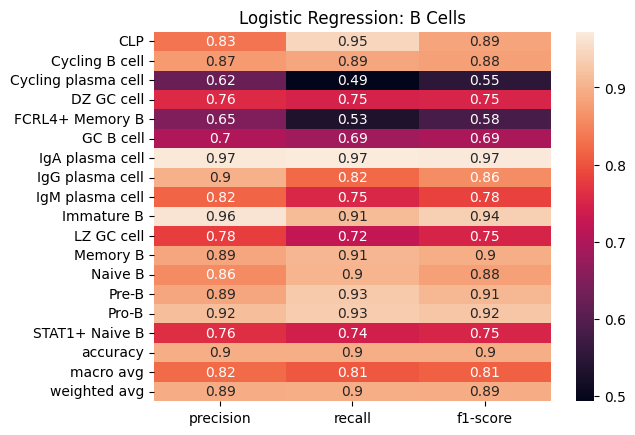

In [18]:

heatmap = sns.heatmap(pd.DataFrame(report).iloc[:-1, :].T, annot=True)
heatmap.set_title('Logistic Regression: B Cells')

In [19]:
# save the heatmap as a file

heatmap_figure = heatmap.get_figure().savefig(file_prefix + 'heatmap.png', bbox_inches = "tight")
# !cp myeloid_forest_heatmap.png /content/drive/MyDrive/scanpyfolder/output


In [20]:
adata

AnnData object with n_obs × n_vars = 40288 × 33538
    obs: 'Sample name', 'Diagnosis', 'Age', 'sample name', 'Region code', 'Fraction', 'Gender', 'Region', '10X', 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'doublet_scores', 'predicted_doublets', 'category', 'Age_group', 'annotation', 'S_score', 'G2M_score', 'phase', 'predicted_annotation'
    var: 'gene_ids', 'feature_types'

In [21]:
# sc.tl.umap(adata)

In [22]:
sc.pp.pca(adata, n_comps=30, random_state=0)

In [23]:
sc.tl.tsne(adata, use_rep='X_pca', random_state=0)

In [24]:
adata

AnnData object with n_obs × n_vars = 40288 × 33538
    obs: 'Sample name', 'Diagnosis', 'Age', 'sample name', 'Region code', 'Fraction', 'Gender', 'Region', '10X', 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'doublet_scores', 'predicted_doublets', 'category', 'Age_group', 'annotation', 'S_score', 'G2M_score', 'phase', 'predicted_annotation'
    var: 'gene_ids', 'feature_types'
    uns: 'pca', 'tsne'
    obsm: 'X_pca', 'X_tsne'
    varm: 'PCs'

In [25]:
adata.obsm['X_tsne']

array([[-40.573997 , -98.96736  ],
       [ 10.697883 , -80.45169  ],
       [-79.713646 ,  -2.1292787],
       ...,
       [ 68.80505  , -26.753363 ],
       [ 93.51614  ,   5.3385315],
       [113.63483  , -38.285854 ]], dtype=float32)

In [26]:
set(adata.obs['annotation'].cat.categories)==set(adata.obs['predicted_annotation'].cat.categories)

True

In [27]:
adata.obs['predicted_annotation_']=adata.obs['predicted_annotation'].cat.reorder_categories(adata.obs['annotation'].cat.categories)

In [28]:
adata.obs['annotation_']=adata.obs['annotation'].copy()
adata.obs['annotation_'][adata.obs['annotation_'].index.isin(
    adata.obs['predicted_annotation_'][adata.obs['predicted_annotation_'].isnull()].index
    )]=np.nan

In [29]:
adata.obs['predicted_annotation_'][~adata.obs['predicted_annotation_'].isnull()]

AAACCTGAGCGATATA-1-4918STDY7333456         Cycling B cell
AAACCTGGTTGGGACA-1-4918STDY7333456    Cycling plasma cell
AAACGGGCACCATCCT-1-4918STDY7333456         Cycling B cell
AAACGGGCATGTTCCC-1-4918STDY7333456                Naive B
AAACGGGTCTGAGTGT-1-4918STDY7333456             DZ GC cell
                                             ...         
TTAGGCAGTTGATTCG-1-WTDAtest7770718        IgA plasma cell
TTGAACGTCCTGCAGG-1-WTDAtest7770718        IgA plasma cell
TTGACTTTCTGTCAAG-1-WTDAtest7770718        IgA plasma cell
TTTACTGAGACTCGGA-1-WTDAtest7770718               Memory B
TTTGGTTGTCGCGTGT-1-WTDAtest7770718        IgA plasma cell
Name: predicted_annotation_, Length: 8058, dtype: category
Categories (16, object): ['CLP', 'Pro-B', 'Pre-B', 'Immature B', ..., 'IgG plasma cell',
                          'IgM plasma cell', 'Cycling B cell', 'Cycling plasma cell']

In [30]:
(adata.obs['annotation_'].index.isin(
    adata.obs['predicted_annotation_'][~adata.obs['predicted_annotation_'].isnull()].index
    )).sum()

8058

In [31]:
adata.obs['annotation_'].isnull().sum()

32230

In [32]:
adata.obs['predicted_annotation_']

AAACCTGAGAACAACT-1-4918STDY7333456               NaN
AAACCTGAGCGATATA-1-4918STDY7333456    Cycling B cell
AAACCTGAGTATCTCG-1-4918STDY7333456               NaN
AAACCTGAGTGACTCT-1-4918STDY7333456               NaN
AAACCTGCACAGATTC-1-4918STDY7333456               NaN
                                           ...      
GCTCCTAAGCAGGCTA-1-WTDAtest7770719               NaN
GTGTTAGAGTGTACCT-1-WTDAtest7770719               NaN
GTTTCTACAGTCGTGC-1-WTDAtest7770719               NaN
TACCTTAGTCGGCACT-1-WTDAtest7770719               NaN
TGGTTAGTCATTGCCC-1-WTDAtest7770719               NaN
Name: predicted_annotation_, Length: 40288, dtype: category
Categories (16, object): ['CLP', 'Pro-B', 'Pre-B', 'Immature B', ..., 'IgG plasma cell',
                          'IgM plasma cell', 'Cycling B cell', 'Cycling plasma cell']

In [33]:
adata.obs['annotation']

AAACCTGAGAACAACT-1-4918STDY7333456         DZ GC cell
AAACCTGAGCGATATA-1-4918STDY7333456     Cycling B cell
AAACCTGAGTATCTCG-1-4918STDY7333456           Memory B
AAACCTGAGTGACTCT-1-4918STDY7333456         DZ GC cell
AAACCTGCACAGATTC-1-4918STDY7333456            Naive B
                                           ...       
GCTCCTAAGCAGGCTA-1-WTDAtest7770719    IgA plasma cell
GTGTTAGAGTGTACCT-1-WTDAtest7770719    IgA plasma cell
GTTTCTACAGTCGTGC-1-WTDAtest7770719    IgA plasma cell
TACCTTAGTCGGCACT-1-WTDAtest7770719    IgA plasma cell
TGGTTAGTCATTGCCC-1-WTDAtest7770719    IgA plasma cell
Name: annotation, Length: 40288, dtype: category
Categories (16, object): ['CLP', 'Pro-B', 'Pre-B', 'Immature B', ..., 'IgG plasma cell',
                          'IgM plasma cell', 'Cycling B cell', 'Cycling plasma cell']

In [34]:
adata.obs['predicted_annotation_'].loc[adata.obs['annotation_'].index]

AAACCTGAGAACAACT-1-4918STDY7333456               NaN
AAACCTGAGCGATATA-1-4918STDY7333456    Cycling B cell
AAACCTGAGTATCTCG-1-4918STDY7333456               NaN
AAACCTGAGTGACTCT-1-4918STDY7333456               NaN
AAACCTGCACAGATTC-1-4918STDY7333456               NaN
                                           ...      
GCTCCTAAGCAGGCTA-1-WTDAtest7770719               NaN
GTGTTAGAGTGTACCT-1-WTDAtest7770719               NaN
GTTTCTACAGTCGTGC-1-WTDAtest7770719               NaN
TACCTTAGTCGGCACT-1-WTDAtest7770719               NaN
TGGTTAGTCATTGCCC-1-WTDAtest7770719               NaN
Name: predicted_annotation_, Length: 40288, dtype: category
Categories (16, object): ['CLP', 'Pro-B', 'Pre-B', 'Immature B', ..., 'IgG plasma cell',
                          'IgM plasma cell', 'Cycling B cell', 'Cycling plasma cell']

In [35]:
adata.obs['predicted_annotation_'].index[adata.obs['predicted_annotation_'].isnull()]

Index(['AAACCTGAGAACAACT-1-4918STDY7333456',
       'AAACCTGAGTATCTCG-1-4918STDY7333456',
       'AAACCTGAGTGACTCT-1-4918STDY7333456',
       'AAACCTGCACAGATTC-1-4918STDY7333456',
       'AAACCTGCATCACCCT-1-4918STDY7333456',
       'AAACCTGGTAGCACGA-1-4918STDY7333456',
       'AAACCTGGTTGGTAAA-1-4918STDY7333456',
       'AAACCTGTCAACACGT-1-4918STDY7333456',
       'AAACCTGTCACAGGCC-1-4918STDY7333456',
       'AAACCTGTCCGAGCCA-1-4918STDY7333456',
       ...
       'TTTGGTTAGAGACGAA-1-WTDAtest7770718',
       'TTTGTCAAGCGTCTAT-1-WTDAtest7770718',
       'ACTGAACGTGTTGAGG-1-WTDAtest7770719',
       'AGAGCTTAGTGCAAGC-1-WTDAtest7770719',
       'CCCAGTTTCAGTTAGC-1-WTDAtest7770719',
       'GCTCCTAAGCAGGCTA-1-WTDAtest7770719',
       'GTGTTAGAGTGTACCT-1-WTDAtest7770719',
       'GTTTCTACAGTCGTGC-1-WTDAtest7770719',
       'TACCTTAGTCGGCACT-1-WTDAtest7770719',
       'TGGTTAGTCATTGCCC-1-WTDAtest7770719'],
      dtype='object', length=32230)

In [36]:
adata.obs['annotation'].cat.categories

Index(['CLP', 'Pro-B', 'Pre-B', 'Immature B', 'Naive B', 'STAT1+ Naive B',
       'GC B cell', 'LZ GC cell', 'DZ GC cell', 'Memory B', 'FCRL4+ Memory B',
       'IgA plasma cell', 'IgG plasma cell', 'IgM plasma cell',
       'Cycling B cell', 'Cycling plasma cell'],
      dtype='object')

In [37]:
adata.obs['predicted_annotation'].cat.categories

Index(['CLP', 'Cycling B cell', 'Cycling plasma cell', 'DZ GC cell',
       'FCRL4+ Memory B', 'GC B cell', 'IgA plasma cell', 'IgG plasma cell',
       'IgM plasma cell', 'Immature B', 'LZ GC cell', 'Memory B', 'Naive B',
       'Pre-B', 'Pro-B', 'STAT1+ Naive B'],
      dtype='object')

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


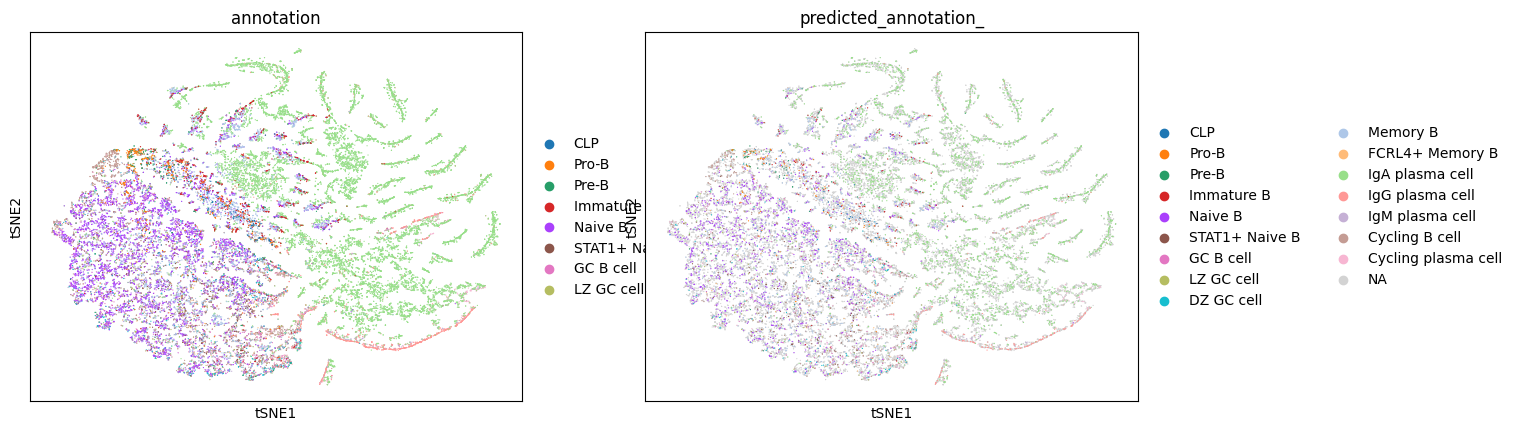

In [38]:
sc.pl.tsne(adata, color=['annotation', 'predicted_annotation_'])

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


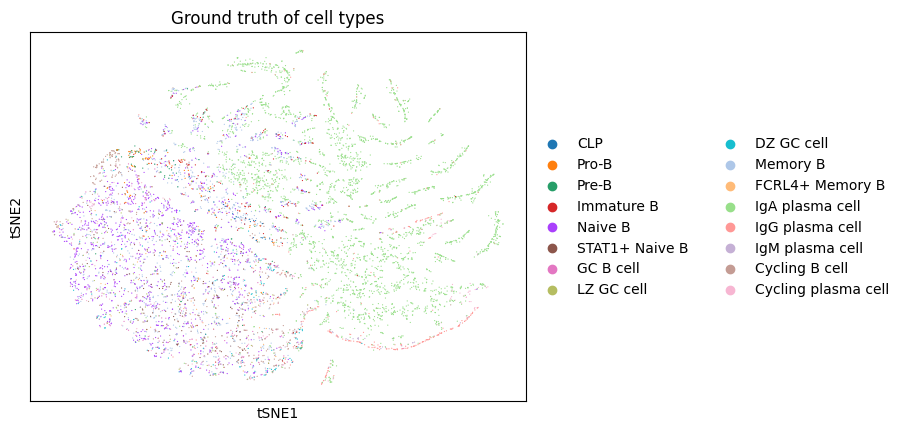

In [39]:
tsne_truth_plot = sc.pl.tsne(adata, color=['annotation_'], title='Ground truth of cell types', na_in_legend=False, na_color='#00000000', return_fig=True)

In [40]:
tsne_truth_plot.get_figure().savefig(file_prefix + 'truth_plot.png', bbox_inches = "tight")

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


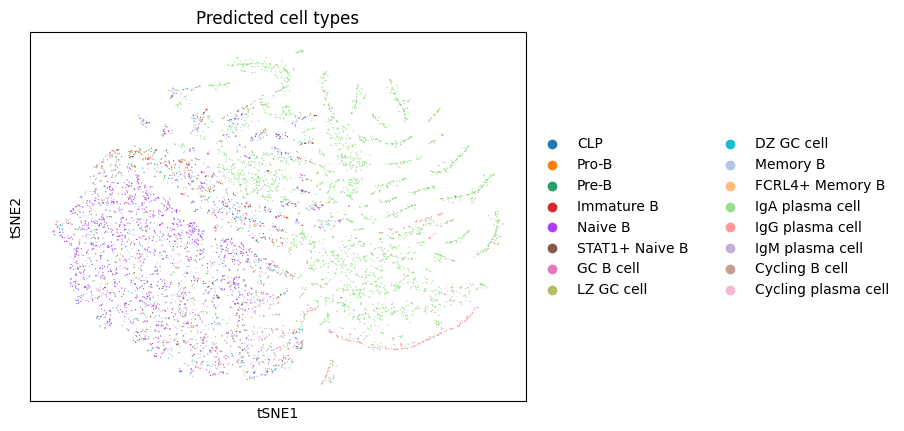

In [41]:
tsne_predicted_plot = sc.pl.tsne(adata, title='Predicted cell types', color=['predicted_annotation_'], na_in_legend=False, na_color='#00000000', return_fig=True)

In [42]:
tsne_predicted_plot.get_figure().savefig(file_prefix + 'predicted_plot.png', bbox_inches = "tight")